## Data

In [1]:
import pandas as pd

from matplotlib import pyplot as plt
import pylab as plot
import logging


pd.options.display.max_columns = 100
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
log = logging.getLogger()

In [2]:
import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv("../data/train.csv")
args.raw_test = pd.read_csv("../data/test.csv")
args.train_border_index = 891
args.val_border_index = 265
args.splits = 5
args.seed = 101
args.n_jobs = -1

In [3]:
print(args.raw_train.shape)
args.raw_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(args.raw_test.shape)
args.raw_test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Unknown data

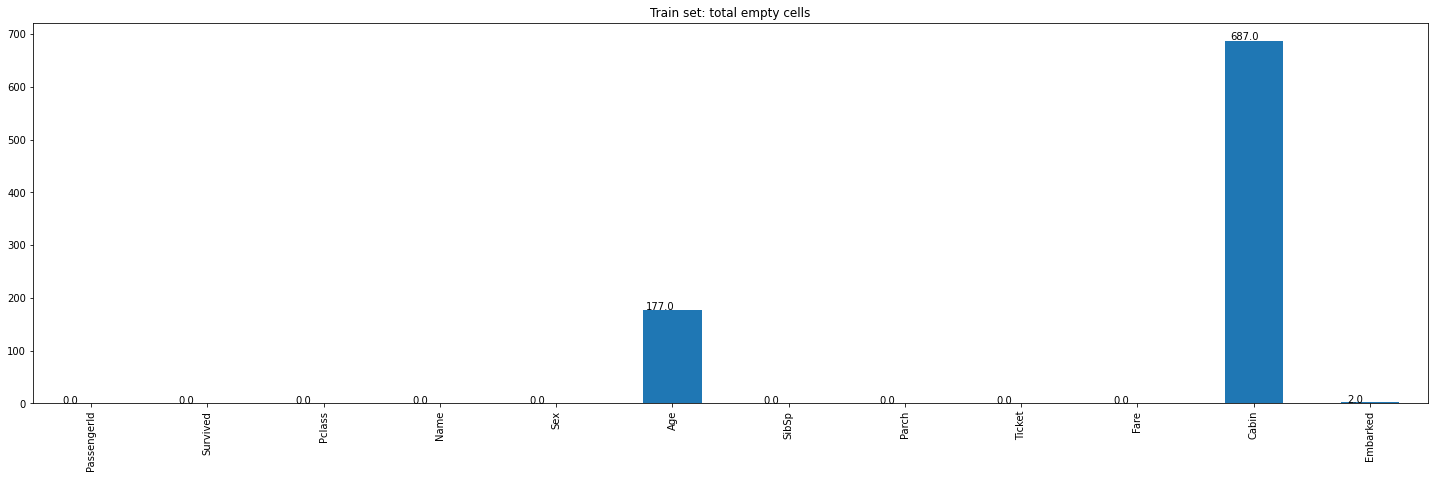

In [5]:
ax = args.raw_train.isna().sum().plot(kind='bar', figsize=(25, 7), stacked=True, title='Train set: total empty cells')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

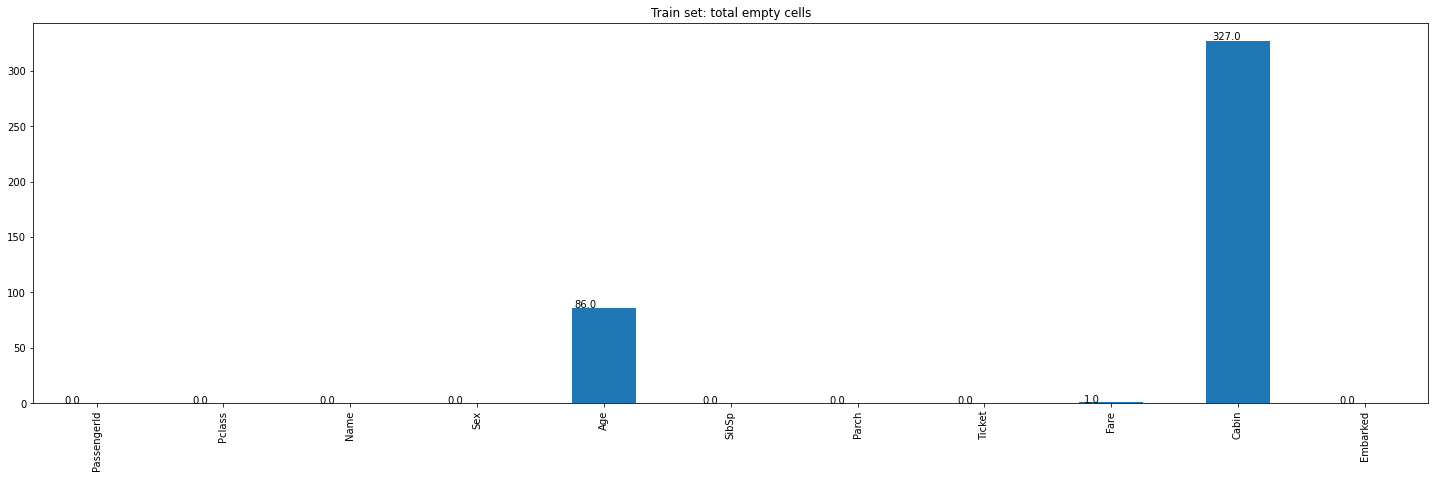

In [6]:
ax = args.raw_test.isna().sum().plot(kind='bar', figsize=(25, 7), stacked=True, title='Train set: total empty cells')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## Feature engineering

In [7]:
X = args.raw_train.copy().drop('Survived', axis=1)
y = args.raw_train.copy()['Survived']
X_test = args.raw_test.copy()

In [8]:
# median age

import numpy as np
from sklearn.pipeline import make_union, Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from functools import reduce
import re

class NameToTitleTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        names = X.to_numpy().reshape(len(X),)
    
        title_dictionary = {
            "Capt": "Officer",
            "Col": "Officer",
            "Major": "Officer",
            "Jonkheer": "Royalty",
            "Don": "Royalty",
            "Sir": "Royalty",
            "Dr": "Officer",
            "Rev": "Officer",
            "the Countess": "Royalty",
            "Mme": "Mrs",
            "Mlle": "Miss",
            "Ms": "Mrs",
            "Mr": "Mr",
            "Mrs": "Mrs",
            "Miss": "Miss",
            "Master": "Master",
            "Lady": "Royalty"
        }
        titles = [fullname.split(',')[1].split('.')[0].strip() for fullname in names]
        short_titles = [title_dictionary.get(title, "Royalty") for title in titles]
        return np.array(short_titles).reshape(len(short_titles), 1)

class SibspParchToFamilySizeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def _categorize_family_size(family_size_row):
            s_size = 0
            m_size = 4
            family_size = reduce(lambda x, y:x+y, family_size_row)
            if family_size == s_size:
                return 's'
            elif family_size <= m_size:
                return 'm'
            else:
                return 'l'
        family_size_categories = list(map(_categorize_family_size, np.asarray(X.to_numpy())))
        return np.array(family_size_categories).reshape(len(family_size_categories), 1)

class TicketTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def _clean_ticket(ticket):
            # replace all special chars
            ticket = re.sub('[^a-zA-Z0-9]', '', ticket)
            if ticket[0].isdigit():
                return 'digit'
            return ticket[0]
        ticket_categories = list(map(_clean_ticket, np.asarray(X.to_numpy().reshape(len(X),))))
        return np.array(ticket_categories).reshape(len(ticket_categories), 1)
    


pclass_pipeline = OneHotEncoder(categories='auto')
name_pipeline = make_pipeline(NameToTitleTransformer(), OneHotEncoder(categories='auto'))
sex_pipeline = OrdinalEncoder(dtype='int')
age_fare_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
sibsp_parch_pipeline = make_pipeline(SibspParchToFamilySizeTransformer(), OneHotEncoder(categories='auto'))
ticket_pipeline = make_pipeline(TicketTransformer(), OneHotEncoder(categories='auto'))
embarked_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(categories='auto'))

feature_engineering_col_transformer = ColumnTransformer(
    [('pclass_transformer', pclass_pipeline, ['Pclass']),
     ('name_transformer', name_pipeline, ['Name']),
     ('sex_transformer', sex_pipeline, ['Sex']),
     ('age_fare_transformer', age_fare_pipeline, ['Age', 'Fare']),
     ('sibsp_parch_transformer', sibsp_parch_pipeline, ['SibSp', 'Parch']),
     ('ticket_transformer', ticket_pipeline, ['Ticket']),
     ('embarked_transformer', embarked_pipeline, ['Embarked'])], 
    remainder='drop'
)

print("X's transformed shape:", feature_engineering_col_transformer.fit_transform(X).shape)

X's transformed shape: (891, 26)


In [9]:
# median age accoring to sex and pclass

import numpy as np
from sklearn.pipeline import make_union, Pipeline, make_pipeline, make_union
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from functools import reduce
import re

class NameToTitleTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        names = X.to_numpy().reshape(len(X),)
    
        title_dictionary = {
            "Capt": "Officer",
            "Col": "Officer",
            "Major": "Officer",
            "Jonkheer": "Royalty",
            "Don": "Royalty",
            "Sir": "Royalty",
            "Dr": "Officer",
            "Rev": "Officer",
            "the Countess": "Royalty",
            "Mme": "Mrs",
            "Mlle": "Miss",
            "Ms": "Mrs",
            "Mr": "Mr",
            "Mrs": "Mrs",
            "Miss": "Miss",
            "Master": "Master",
            "Lady": "Royalty"
        }
        titles = [fullname.split(',')[1].split('.')[0].strip() for fullname in names]
        short_titles = [title_dictionary.get(title, "Royalty") for title in titles]
        return np.array(short_titles).reshape(len(short_titles), 1)

class SibspParchToFamilySizeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def _categorize_family_size(family_size_row):
            s_size = 0
            m_size = 4
            family_size = reduce(lambda x, y:x+y, family_size_row)
            if family_size == s_size:
                return 's'
            elif family_size <= m_size:
                return 'm'
            else:
                return 'l'
        family_size_categories = list(map(_categorize_family_size, np.asarray(X.to_numpy())))
        return np.array(family_size_categories).reshape(len(family_size_categories), 1)

class TicketTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def _clean_ticket(ticket):
            # replace all special chars
            ticket = re.sub('[^a-zA-Z0-9]', '', ticket)
            if ticket[0].isdigit():
                return 'digit'
            return ticket[0]
        ticket_categories = list(map(_clean_ticket, np.asarray(X.to_numpy().reshape(len(X),))))
        return np.array(ticket_categories).reshape(len(ticket_categories), 1)
    


pclass_pipeline = OneHotEncoder(categories='auto')
name_pipeline = make_pipeline(NameToTitleTransformer(), OneHotEncoder(categories='auto'))
sex_pipeline = OrdinalEncoder(dtype='int')
fare_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
sibsp_parch_pipeline = make_pipeline(SibspParchToFamilySizeTransformer(), OneHotEncoder(categories='auto'))
ticket_pipeline = make_pipeline(TicketTransformer(), OneHotEncoder(categories='auto'))
embarked_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(categories='auto'))

feature_engineering_col_transformer_wo_age = ColumnTransformer(
    [('pclass_transformer', pclass_pipeline, ['Pclass']),
     ('name_transformer', name_pipeline, ['Name']),
     ('sex_transformer', sex_pipeline, ['Sex']),
     ('fare_transformer', fare_pipeline, ['Fare']),
     ('sibsp_parch_transformer', sibsp_parch_pipeline, ['SibSp', 'Parch']),
     ('ticket_transformer', ticket_pipeline, ['Ticket']),
     ('embarked_transformer', embarked_pipeline, ['Embarked'])], 
    remainder='drop'
)

class CategoryMedianAgeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def _fill_age_median_row(row):
            if np.isnan(row['Age']):
                return median_ages[(median_ages['Sex'] == row['Sex']) 
                                  & (median_ages['Pclass'] == row['Pclass'])]['Age'].values[0]
            return row['Age']
        median_ages = X.groupby(['Sex', 'Pclass']).median().reset_index()[['Sex', 'Pclass', 'Age']]
        filled_age = X.apply(lambda row: _fill_age_median_row(row), axis=1)
        return filled_age.to_numpy().reshape(-1, 1)

age_pipeline = make_pipeline(CategoryMedianAgeTransformer(), StandardScaler())

feature_engineering_col_transformer_category_median_age = ColumnTransformer(
    [('age_transformer', age_pipeline, ['Age', 'Sex', 'Pclass'])], 
    remainder='drop'
)

feature_engineering_union_transformer = make_union(feature_engineering_col_transformer_wo_age, 
                                                   feature_engineering_col_transformer_category_median_age)

log.info("X's transformed shape with category median age: %s", feature_engineering_union_transformer.fit_transform(X).shape)

2020-11-28 19:07:15,650 : INFO : X's transformed shape with category median age: (891, 26)


## Pipeline

In [10]:
def csv_predictions(predictions, filename):
    submission = pd.DataFrame({'PassengerId': args.raw_test['PassengerId'],'Survived': predictions})

    submission.to_csv(filename, index=False)
    print('Saved file: ' + filename)

In [11]:
# median age
from sklearn.ensemble import ExtraTreesClassifier

pipeline_clf = ExtraTreesClassifier(random_state=args.seed, n_jobs=-1, 
                                    **{'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10})

titanic_pipeline = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('clf', pipeline_clf)
    ]
)

titanic_pipeline.fit(X, y)

def get_feature_names(pipeline):
    feature_names = []
    for transformer in pipeline.named_steps['feature-engineering'].transformers_:
        if 'transformer' not in transformer[0]:
            continue
        transformer_class = transformer[1]
        if type(transformer_class) is OneHotEncoder:
            feature_names.extend(transformer_class.get_feature_names(transformer[2]).tolist())
        elif type(transformer_class) is Pipeline:
            if transformer[2][0] is 'SibSp':
                feature_names.extend(transformer_class.steps[-1][-1].get_feature_names(['FamilySize']).tolist())
            elif transformer[2][0] is 'Name':
                feature_names.extend(transformer_class.steps[-1][-1].get_feature_names(['Title']).tolist())
            elif type(transformer_class.steps[-1][-1]) is OneHotEncoder:
                for col_name in transformer[2]:
                    feature_names.extend(transformer_class.steps[-1][-1].get_feature_names([col_name]).tolist())
            else:
                feature_names.extend(transformer[2])
        else:
            feature_names.extend(transformer[2])
    assert len(feature_names) == 26
    return feature_names

def print_feature_importances(pipeline):
    fi = [fi for fi in zip(get_feature_names(pipeline), 
                                    pipeline.named_steps['clf'].feature_importances_.tolist())]
    fi = list(map(lambda i: (i[0], round(i[-1], 3)), fi))
    fi = sorted(fi, key=lambda i: i[-1], reverse=True)
    log.info("Feature importances: %s", repr(fi))
             
print_feature_importances(titanic_pipeline)

predictions_pipeline = titanic_pipeline.predict(X_test).astype(int)
csv_predictions(predictions_pipeline, '../predictions/titanic-pipeline-median-age-extra-trees.csv')

2020-11-28 19:07:16,039 : INFO : Feature importances: [('Title_Mr', 0.33), ('Sex', 0.237), ('Pclass_3', 0.115), ('Pclass_1', 0.041), ('Fare', 0.039), ('FamilySize_l', 0.039), ('Pclass_2', 0.032), ('Title_Master', 0.029), ('Title_Mrs', 0.026), ('Title_Officer', 0.026), ('Age', 0.015), ('Embarked_S', 0.014), ('Embarked_C', 0.011), ('FamilySize_m', 0.01), ('Title_Miss', 0.008), ('Embarked_Q', 0.008), ('FamilySize_s', 0.006), ('Ticket_S', 0.005), ('Ticket_P', 0.004), ('Ticket_digit', 0.003), ('Ticket_C', 0.001), ('Title_Royalty', 0.0), ('Ticket_A', 0.0), ('Ticket_F', 0.0), ('Ticket_L', 0.0), ('Ticket_W', 0.0)]


Saved file: ../predictions/titanic-pipeline-median-age-extra-trees.csv


In [12]:
# category median age
titanic_pipeline = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_union_transformer),
        ('clf', pipeline_clf)
    ]
)

titanic_pipeline.fit(X, y)
predictions_pipeline = titanic_pipeline.predict(X_test).astype(int)
csv_predictions(predictions_pipeline, '../predictions/titanic-pipeline-category-median-age-extra-trees.csv')

Saved file: ../predictions/titanic-pipeline-category-median-age-extra-trees.csv


## Gridsearch pipeline

In [13]:
# look for the best params
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from collections import namedtuple


svm = SVC(random_state=args.seed)
rf = RandomForestClassifier(random_state=args.seed)
et =  ExtraTreesClassifier(random_state=args.seed)
mlp = MLPClassifier(random_state=args.seed)
xgb = XGBClassifier(random_state=args.seed)

clfs = [svm, rf, et, mlp, xgb]
param_grids = [
    {
        'clf__C': [1, 10],
        'clf__kernel': ['linear', 'rbf', 'poly'],
        'clf__gamma': [0.01, 0.001]
    },
    {
        'clf__n_estimators': [15, 25, 50],
        'clf__max_features': [5, 7, 10],
        'clf__min_samples_leaf': [1, 3, 5],
        'clf__max_depth': [25, 40]
    },
    {
        'clf__n_estimators': [15, 25, 50],
        'clf__max_features': [5, 7, 10],
        'clf__min_samples_leaf': [1, 3, 5],
        'clf__max_depth': [25, 40]
    },
    {
        'clf__hidden_layer_sizes': [(128, ), (512, 64, ), (128, 16), (16, 4)],
        'clf__alpha': [0.01, 1],
        'clf__max_iter': [50, 250, 500],
        'clf__early_stopping': [False, True]
    },
    {
        'clf__n_estimators': [15, 25, 50],
        'clf__max_depth': [25, 40],
        'clf__learning_rate': [0.001, 0.1],
        'clf__booster': ['gbtree', 'gblinear', 'dart'],
    }
]

BestPipeline = namedtuple('BestPipeline', 'instance cv_score')
best_pipeline = BestPipeline(None, float("-inf"))

for clf, clf_params in zip(clfs, param_grids):
    titanic_pipeline = Pipeline(
        steps=[
            ('feature_engineering', feature_engineering_col_transformer),
            ('clf', clf)
        ]
    )
    params_grid = {
        'feature_engineering': [feature_engineering_col_transformer, feature_engineering_union_transformer]
    }
    params_grid.update(clf_params)
    skf = StratifiedKFold(n_splits=args.splits, shuffle=True, random_state=args.seed)
    grd = GridSearchCV(titanic_pipeline, param_grid = params_grid, cv=skf, verbose=1, n_jobs=args.n_jobs)
    grd.fit(X, y)
    log.info('Clf: %s. CV score: %s.', 
             repr(type(grd.best_estimator_.named_steps.clf).__name__), 
             repr(grd.best_score_))
    if grd.best_score_ > best_pipeline.cv_score:
        best_pipeline = BestPipeline(grd.best_estimator_, grd.best_score_)
    

log.info(best_pipeline)
if type(best_pipeline.instance.named_steps['clf']).__name__ is 'RandomForestClassifier' or \
    type(best_pipeline.instance.named_steps['clf']).__name__ is 'ExtraTreesClassifier':
    log.info("Feature importances: %s", repr(best_pipeline.instance.named_steps['clf'].feature_importances_))
predictions_pipeline = best_pipeline.instance.predict(X_test).astype(int)
csv_predictions(predictions_pipeline, '../predictions/titanic-pipeline-grd.csv')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   21.6s finished
2020-11-28 19:07:39,787 : INFO : Clf: 'SVC'. CV score: 0.8204506936162199.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.5min finished
2020-11-28 19:09:10,288 : INFO : Clf: 'RandomForestClassifier'. CV score: 0.8327914129684263.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.4min finished
2020-11-28 19:10:35,478 : INFO : Clf: 'ExtraTreesClassifier'. CV score: 0.826062394074446.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  7.9min finished
/Users/glaizier/github/titanic-prediction/.venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
2020-11-28 19:18:34,161 : INFO : Clf: 'MLPClassifier'. CV score: 0.8271922666499278.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.1min finished
2020-11-28 19:19:40,483 : INFO : Clf: 'XGBClassifier'. CV score: 0.827154604230745.
2020-11-28 19:19:40,488 : INFO : BestPipeline(instance=Pipeline(steps=[('feature_engineering',
                 ColumnTransformer(transformers=[('pclass_transformer',
                                                  OneHotEncoder(), ['Pclass']),
                                                 ('name_transformer',
                                                  Pipeline(steps=[('nametotitletransformer',
                                                                   NameToTitleTransformer()),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                              

Saved file: ../predictions/titanic-pipeline-grd.csv


#### Test score pipeline

|  Model | Params | Test score |
|---|---|---|
| Extra trees (median age) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.78468 |
| Extra trees (category median age) | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 | 0.77272 |
| Grid search (random forest, median age) | max_depth=25, max_features=10, min_samples_leaf=3, n_estimators=50 | 0.76794 |